In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split


from LookaheadCQR.lookahead.models.lookahead import Lookahead
import LookaheadCQR.lookahead.models.uncertainty as uncert
import LookaheadCQR.lookahead.models.prediction as pred
import LookaheadCQR.lookahead.models.propensity as prop
from LookaheadCQR.lookahead.models.models import polyRegression

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
np.set_printoptions(precision=3)

## Setting the data hyperparameters

In [2]:
# Random Seed
seed = 3

# Coefficients of the ground truth polynomial
# coeffs[i] denotes the coefficient of x^i th term
coeffs = [0.1, 0.5, -0.8]

# Number of Training Samples
n = 25  

# Our input is drawn from the normal distribution 
# with std = sig and mean = offset
sig = 0.5
offset = -0.8

# std of noise added to the data
ns = 0.25

# Split ratio for train-test
trn_sz = 0.75

# Degree of polynomial regressor
degree = 2 

## Defining the ground truth function f*

f*(x) =  -0.8 x<sup>2</sup> + 0.5 x + 0.1

In [3]:
class Fstar():
    def __init__(self, coeffs = []):
        self.coeffs = coeffs
    def fit(self, x, y):
        pass
    def predict(self, x):
        c = self.coeffs[-1]
        for i in range(2, len(self.coeffs) + 1):
            c = self.coeffs[-i] + c*x
        return c.flatten()

In [4]:
np.random.seed(seed)
fstar = Fstar(coeffs)
x = np.random.normal(size = (n, 1), scale = sig) + offset
y = fstar.predict(x)
y += np.random.normal(scale = ns, size = y.shape)

n, d = x.shape
x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, test_size = 1 - trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print("n:", n, ", n_trn:", n_trn, ", n_tst:", n_tst)
xs = [x_trn, x_tst, x]
ys = [y_trn, y_tst, y]

n: 25 , n_trn: 18 , n_tst: 7


## Setting the model hyperparamters

In [5]:
# l1/l2 Regularization coefficient
alpha = 0.
# Lam controls the tradeoff between accuracy and decision improvement
lam = 4.

" Hyperparamteres for Lookahead"
# Decision step size
eta = 1.25
# Number of cycles for training
num_cycles = 5
# Z-score controls size of confidence intervas
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# Learning rate
lr_f = 0.05
# Number of training iterations
num_iter_init = 1000
num_iter_f = 100
num_iter_base = num_iter_init + num_iter_f*num_cycles

""" Hyperparameters for Uncertanity Model"""
#number of bootstrapped models
num_gs = 10 
# Learning rate
lr_g = 0.05
# Number of training iterations
num_iter_g = 3000 #for training g in cycles

""" Mask""" 
# mask[i] is 1 if it can be changed for making decisions
mask = np.ones(d)
print('mask:', mask)

mask: [1.]


In [6]:
# Helper functions to print performance
def get_perf(model, xs, ys, eta, mask, uncert=False):
    perf = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    perf['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    if uncert:
        xsp = [model.move_points(x_) for x_ in xs]
        perf['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf = {k:np.asarray(v) for k,v in zip(perf.keys(),perf.values())}
    return perf
    
def print_perf(perf, idx=0, uncert=False):
    print('\ttrn\ttst\tall')
    print(('mse'+'\t{:.4f}'*3).format(*perf['mse'][idx,:]))
    print(('mae'+'\t{:.4f}'*3).format(*perf['mae'][idx,:]))
    print(('imprv'+'\t{:.4f}'*3).format(*perf['improve'][idx,:]))
    print(('imprt'+'\t{:.4f}'*3).format(*perf['imprate'][idx,:]))
    print()
    if uncert:
        print('\ttrn\'\ttst\'\tall')
        print(('contn'+'\t{:.3f}'*3).format(*perf['contain'][idx,:]))
        print(('intrsz'+'\t{:.3f}'*3).format(*perf['size'][idx,:]))
        print()

## Training the baseline model with no lookahead regularization

In [7]:
# train baseline
verbose = True

print('training baseline:')
f_model = polyRegression(1, 1, degree)
f_base = pred.PredModel(d, model=f_model, reg_type='none', alpha=alpha, lr=lr_f, num_iter_init=num_iter_base)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

perf_base = get_perf(model_base, xs, ys, eta, mask)
print_perf(perf_base)

training baseline:
t: 0
[f] mse: 0.0410, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0410
[f] improve*: -0.539

	trn	tst	all
mse	0.0410	0.1175	0.0624
mae	0.1473	0.3236	0.1966
imprv	-0.5392	-0.2610	-0.4613
imprt	0.1667	0.4286	0.2400



## Training the lookahead model

In [8]:
# train our model
verbose = True

print('Training lookahead:')
f_model = polyRegression(1, 1, degree)
g_model = polyRegression(1, 1, degree)

f = pred.PredModel(d, model = f_model, reg_type='none', alpha=0., lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
u = uncert.Bootstrap(d, model = g_model, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
h = prop.PropModel(random_state=seed)
model = Lookahead(f, u, h, lam=lam, eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

Training lookahead:
t: 0
[f] mse: 0.0428, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0428
[f] improve*: -0.428

t: 1
[h] n_eff: 5.58, w_sum: 1.54
[u] loss: 0.0089, norm_reg: 0.0000, obj: 0.0089
[u] size: 4.853, contain*: 1.000
[f] mse: 0.2113, la_reg: 0.0362, norm_reg: 0.0000, obj: 0.3562
[f] improve*: 1.344

t: 2
[h] n_eff: 4.38, w_sum: 4.60
[u] loss: 0.0077, norm_reg: 0.0000, obj: 0.0077
[u] size: 1.437, contain*: 1.000
[f] mse: 0.1630, la_reg: 0.0233, norm_reg: 0.0000, obj: 0.2563
[f] improve*: 1.222

t: 3
[h] n_eff: 4.51, w_sum: 3.64
[u] loss: 0.0078, norm_reg: 0.0000, obj: 0.0078
[u] size: 1.835, contain*: 1.000
[f] mse: 0.1689, la_reg: 0.0232, norm_reg: 0.0000, obj: 0.2619
[f] improve*: 1.239

t: 4
[h] n_eff: 4.49, w_sum: 3.75
[u] loss: 0.0078, norm_reg: 0.0000, obj: 0.0078
[u] size: 1.784, contain*: 1.000
[f] mse: 0.1666, la_reg: 0.0236, norm_reg: 0.0000, obj: 0.2612
[f] improve*: 1.233

t: 5
[h] n_eff: 4.50, w_sum: 3.71
[u] loss: 0.0078, norm_reg: 0.0000, obj: 0.0078
[u] size: 1.

## Comparing the performance of baseline model vs model trained with lookahead regularization

In [9]:
perf_base = get_perf(model_base, xs, ys, eta, mask)
perf_la = get_perf(model, xs, ys, eta, mask, uncert=True)

print('\nBaseline Model:')
print_perf(perf_base)
print('Lookahead Model:')
print_perf(perf_la, uncert=True)


Baseline Model:
	trn	tst	all
mse	0.0410	0.1175	0.0624
mae	0.1473	0.3236	0.1966
imprv	-0.5392	-0.2610	-0.4613
imprt	0.1667	0.4286	0.2400

Lookahead Model:
	trn	tst	all
mse	0.1669	0.1797	0.1705
mae	0.3377	0.3359	0.3372
imprv	1.2347	1.0653	1.1873
imprt	1.0000	0.8571	0.9600

	trn'	tst'	all
contn	1.000	1.000	1.000
intrsz	1.797	1.551	1.728



## Plotting the results
The main plot shows the predictions generated by the lookahead model.  The inlay plot shows the performance of the baseline classifier 

In [10]:
# Helper function for plotting
def plot_quad(ax, M, x, y, x_plot, y_plot, eta, mask, lw=1, osz=50, olw=1):
    x_plot_th = torch.from_numpy(x_plot.astype(np.float32))
    ax.plot(x_plot, y_plot, '--', color="tab:orange", linewidth =1.0, label ="gt", alpha=0.6)

    f_pred = M.f.predict(x_plot)
    ax.plot(x_plot, f_pred, label="f", linewidth=lw, alpha=0.6)

    if M.u is not None:
        u_pred, l_pred = M.u.lu(x_plot_th)
        u_pred = u_pred.detach().numpy()
        l_pred = l_pred.detach().numpy()
        ax.fill_between(x_plot.flatten(), u_pred.flatten(), l_pred.flatten(),  color='g', alpha=0.05, zorder=0)
        ax.plot(x_plot.flatten(), u_pred.flatten(), "tab:green", linewidth=1.0, alpha=0.5, zorder=0)
        ax.plot(x_plot.flatten(), l_pred.flatten(), "tab:green", linewidth=1.0, alpha=0.5, zorder=0)

    xp = M.move_points(x, eta, mask)
    ypstar = M.fstar.predict(xp)
    ax.scatter(x, y, color="white", edgecolor="tab:blue", alpha = 1, s=osz, zorder=10, linewidth=olw)
    ax.scatter(xp, ypstar, color="white", edgecolor="tab:red", alpha = 1, s=osz, zorder=10, linewidth=olw)

    ax.set_xticks([])
    ax.set_yticks([])

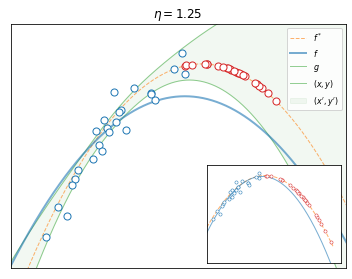

In [11]:
plt.rcParams['figure.figsize'] = (6.0, 4.5)
x_plot = np.linspace(-3.0, 3.0, 1000)[:, np.newaxis]
y_plot = fstar.predict(x_plot)

ax = plt.axes()
plot_quad(ax, model, x, y, x_plot, y_plot, eta, mask, lw=2)
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-4, 1])
plt.title(r'$\eta={}$'.format(eta))

axins = inset_axes(ax, width="40%", height="40%", loc=4)
plot_quad(axins, model_base, x, y, x_plot, y_plot, eta, mask, osz=10, olw=0.5)
axins.set_xlim([-2, 3.3])
axins.set_ylim([-7, 1.0])

ax.legend([r'$f^*$',r'$f$',r'$g$',r'$(x,y)$',r"$(x',y')$"],fontsize=8)

plt.show()